In [3]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from scipy.stats import chi2
from scipy.special import erfinv
from scipy.special import erfcinv


# import libraries:
import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import numpy as np
import git
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../..')))



def estimate_centroid_and_covariance(means, covariances):
    means = np.array(means)
    covariances = np.array(covariances)
    
    # Calculate the inverse of each covariance matrix
    inv_covariances = np.linalg.inv(covariances)
    
    # Calculate the weighted sum of the means
    weighted_means = np.einsum('ijk,ik->ij', inv_covariances, means)
    sum_inv_covariances = np.sum(inv_covariances, axis=0)
    
    # Calculate the centroid
    centroid = np.linalg.solve(sum_inv_covariances, np.sum(weighted_means, axis=0))
    
    # Calculate the covariance of the centroid
    centroid_covariance = np.linalg.inv(sum_inv_covariances)
    
    return centroid, centroid_covariance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import cosmological data

In [4]:
import git, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))
#Fixed Parameters
num_parameters = 2
num_datasets = 4

num_samples = 10000
'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''


# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))

os.chdir(os.path.join(path_global,'montepython_public_old','output'))   
#os.chdir('/home/matias/Documents/PhD/code/montepython_public_old/output')

#Fixed Parameters
#num_parameters = 2
#num_datasets = 4

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples .loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})


param_names = ['Omega_m','H0'] #Shared paameters

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)
mean_D = chain_D.mean(param_names)
cov_D = chain_D.cov(param_names)

Path to git repo: /home/matias/Documents/PhD/code


# Anova-like stimators

In [5]:
#mean_bar = (mean_A + mean_B + mean_C)/num_datasets

cov_tot = cov_A + cov_B + cov_C + cov_D
#cov_bar = cov_tot / num_datasets**2

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_C, mean_D], [cov_A, cov_B, cov_C, cov_D])
mean_bar = centroid
cov_bar = centroid_covariance

samps_bar = np.random.multivariate_normal(mean_bar, cov_bar, size=10000)
chain_bar = MCSamples(samples=samps_bar, names=param_names, labels=param_names, label='Bar')
colors = ['red', 'blue', 'green', 'purple', 'black']

delta_theta_A = mean_A - mean_bar
delta_theta_B = mean_B - mean_bar
delta_theta_C = mean_C - mean_bar
delta_theta_D = mean_D - mean_bar

In [6]:
samps_A_H0 = np.random.multivariate_normal(0*mean_A, cov_A, size=num_samples)
samps_B_H0 = np.random.multivariate_normal(0*mean_B, cov_B, size=num_samples)
samps_C_H0 = np.random.multivariate_normal(0*mean_C, cov_C, size=num_samples)
samps_D_H0 = np.random.multivariate_normal(0*mean_D, cov_D, size=num_samples)
samps_bar_H0 = np.random.multivariate_normal(0*mean_bar, cov_bar, size=num_samples)

samps_delta_theta_AB_H0 = samps_A_H0 - samps_B_H0
samps_delta_theta_AC_H0 = samps_A_H0 - samps_C_H0
samps_delta_theta_BC_H0 = samps_B_H0 - samps_C_H0
samps_delta_theta_AD_H0 = samps_A_H0 - samps_D_H0
samps_delta_theta_BD_H0 = samps_B_H0 - samps_D_H0
samps_delta_theta_CD_H0 = samps_C_H0 - samps_D_H0


samps_delta_theta_A_H0 = samps_A_H0 - samps_bar_H0
samps_delta_theta_B_H0 = samps_B_H0 - samps_bar_H0
samps_delta_theta_C_H0 = samps_C_H0 - samps_bar_H0
samps_delta_theta_D_H0 = samps_D_H0 - samps_bar_H0


## $\alpha$-stimator

\begin{equation}
    \alpha = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\sum_{j} C_j}  (\theta_i - \bar{\theta})
\end{equation}

alpha: 6.081778470204835
[1.22129804 1.94928114 2.90500277 ... 1.17572892 1.03570472 0.45739281]
PTE: 0.0316
$N \sigma$:2.14943


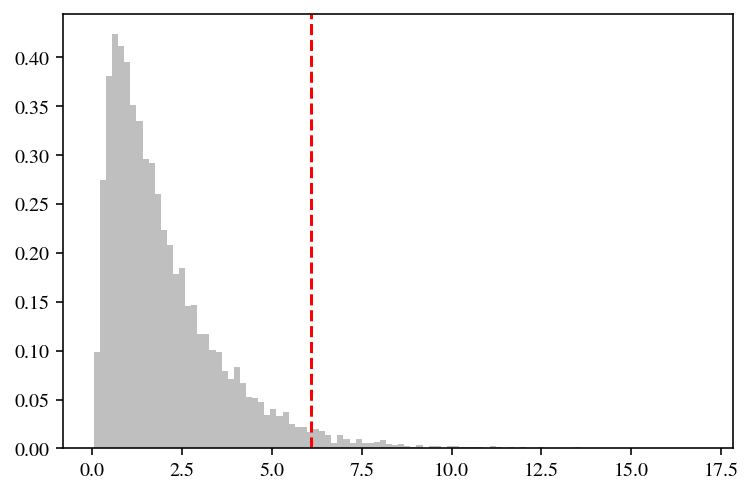

In [7]:
# Utility function to convert confidence level to sigma level
def from_confidence_to_sigma(confidence):
    return np.sqrt(2) * erfinv(confidence)

A_matrix = np.linalg.inv(cov_tot)

alpha = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C)) \
      + np.dot(delta_theta_D.T,np.dot(A_matrix, delta_theta_D))

print(r'alpha: {}'.format(alpha))

samples_H0 = np.zeros(num_samples)
for i in range(len(samples_H0)):
    samples_H0[i] = \
      np.dot(samps_delta_theta_A_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_A_H0[i,:])) \
    + np.dot(samps_delta_theta_B_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_B_H0[i,:]))\
    + np.dot(samps_delta_theta_C_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_C_H0[i,:]))\
    + np.dot(samps_delta_theta_D_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_D_H0[i,:]))


plt.hist(samples_H0, bins=100, density=True, alpha=0.5, color='gray', label='H0 samples')
plt.axvline(alpha, color='red', linestyle='--', label='alpha')

print(samples_H0)
PTE = samples_H0[samples_H0 > alpha].size/samples_H0.size
print('PTE: {}'.format(PTE))
print(r'$N \sigma$:{:4g}'.format(np.sqrt(2) * erfcinv(PTE)))


## $\beta$-stimator

\begin{equation}
    \beta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j)
\end{equation}

beta: 64.98853419215999
[ 7.27019256  8.93438268 16.35535312 ...  9.97689038 12.01098192
  3.06692087]
PTE: 0.0002
$N \sigma$:3.71902


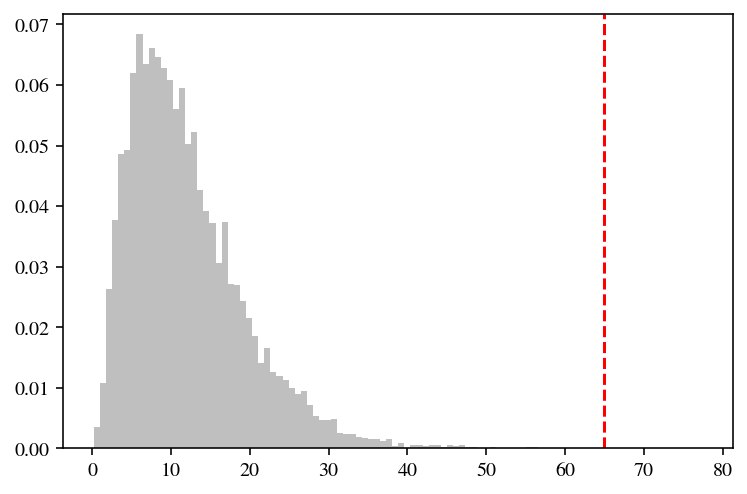

In [8]:
beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
     + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
     + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C))) \
     + np.dot((mean_A - mean_D).T, np.dot(np.linalg.inv(cov_A + cov_D), (mean_A - mean_D))) \
     + np.dot((mean_B - mean_D).T, np.dot(np.linalg.inv(cov_B + cov_D), (mean_B - mean_D))) \
     + np.dot((mean_C - mean_D).T, np.dot(np.linalg.inv(cov_C + cov_D), (mean_C - mean_D)))


print(r'beta: {}'.format(beta))

samples_H0 = np.zeros(num_samples)
for i in range(len(samples_H0)):
    samples_H0[i] = \
      np.dot(samps_delta_theta_AB_H0[i,:].T,np.dot(np.linalg.inv(cov_A + cov_B), samps_delta_theta_AB_H0[i,:])) \
    + np.dot(samps_delta_theta_AC_H0[i,:].T,np.dot(np.linalg.inv(cov_A + cov_C), samps_delta_theta_AC_H0[i,:]))\
    + np.dot(samps_delta_theta_BC_H0[i,:].T,np.dot(np.linalg.inv(cov_B + cov_C), samps_delta_theta_BC_H0[i,:]))\
     + np.dot(samps_delta_theta_AD_H0[i,:].T,np.dot(np.linalg.inv(cov_A + cov_D), samps_delta_theta_AD_H0[i,:]))\
     + np.dot(samps_delta_theta_BD_H0[i,:].T,np.dot(np.linalg.inv(cov_B + cov_D), samps_delta_theta_BD_H0[i,:]))\
     + np.dot(samps_delta_theta_CD_H0[i,:].T,np.dot(np.linalg.inv(cov_C + cov_D), samps_delta_theta_CD_H0[i,:]))


samples_H0 = np.array(samples_H0)
plt.hist(samples_H0, bins=100, density=True, alpha=0.5, color='gray', label='H0 samples')
plt.axvline(beta, color='red', linestyle='--', label='beta')

print(samples_H0)
PTE = samples_H0[samples_H0 > beta].size/samples_H0.size
print('PTE: {}'.format(PTE))
print(r'$N \sigma$:{:4g}'.format(np.sqrt(2) * erfcinv(PTE)))

In [9]:

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''
print(r'Diferentes términos de $\beta$:')
print('CC+Planck18:', np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))))
print('CC+BAO:',np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))))
print('Planck18+BAO:',np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C))))
print('CC+PPS:',np.dot((mean_A - mean_D).T, np.dot(np.linalg.inv(cov_A + cov_D), (mean_A - mean_D))))
print('Planck18+PPS:',np.dot((mean_B - mean_D).T, np.dot(np.linalg.inv(cov_B + cov_D), (mean_B - mean_D))))
print('BAO+PPS:',np.dot((mean_C - mean_D).T, np.dot(np.linalg.inv(cov_C + cov_D), (mean_C - mean_D))))

Diferentes términos de $\beta$:
CC+Planck18: 0.5381290661527729
CC+BAO: 2.78901479292658
Planck18+BAO: 4.198605436052161
CC+PPS: 10.382340622752851
Planck18+PPS: 45.28306372417411
BAO+PPS: 1.7973805501015017


## $\gamma$-stimator

\begin{equation}
    \gamma = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_{i}}  (\theta_i - \bar{\theta})
\end{equation}

gamma: 50.64708973159843
[15.24133234  7.12781101  7.02926292 ... 10.05393609  8.175955
  1.91066268]
PTE: 0.0
$N \sigma$: inf


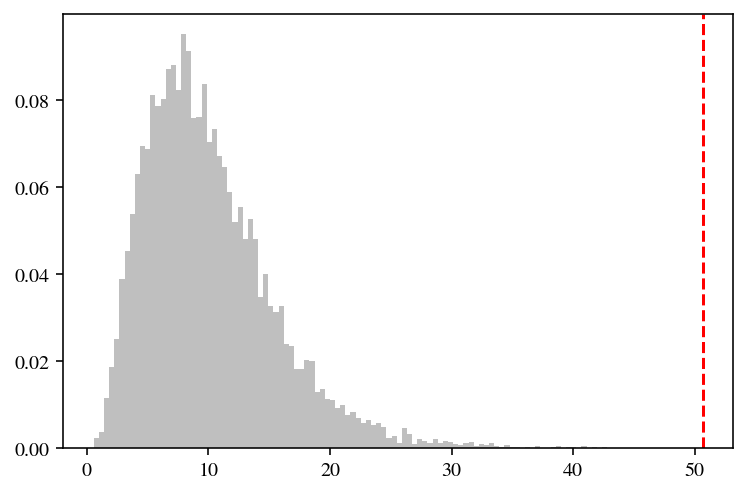

In [10]:
gamma = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A), delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B), delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C), delta_theta_C)) \
      + np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D), delta_theta_D))

print(r'gamma: {}'.format(gamma))

samples_H0 = np.zeros(num_samples)
for i in range(len(samples_H0)):
    samples_H0[i] = \
      np.dot(samps_delta_theta_A_H0[i,:].T,np.dot(np.linalg.inv(cov_A), samps_delta_theta_A_H0[i,:])) \
    + np.dot(samps_delta_theta_B_H0[i,:].T,np.dot(np.linalg.inv(cov_B), samps_delta_theta_B_H0[i,:]))\
    + np.dot(samps_delta_theta_C_H0[i,:].T,np.dot(np.linalg.inv(cov_C), samps_delta_theta_C_H0[i,:]))\
    + np.dot(samps_delta_theta_D_H0[i,:].T,np.dot(np.linalg.inv(cov_D), samps_delta_theta_D_H0[i,:]))
    

samples_H0 = np.array(samples_H0)
plt.hist(samples_H0, bins=100, density=True, alpha=0.5, color='gray', label='H0 samples')
plt.axvline(gamma, color='red', linestyle='--', label='gamma')

print(samples_H0)
PTE = samples_H0[samples_H0 > gamma].size/samples_H0.size
print('PTE: {}'.format(PTE))
print(r'$N \sigma$:{:4g}'.format(np.sqrt(2) * erfcinv(PTE)))


In [11]:

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''
print(r'Diferentes términos de $\gamma$:')
print('CC:', np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A), delta_theta_A)))
print('Planck18:',np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B), delta_theta_B)))
print('BAO:',np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C), delta_theta_C)))
print('PPS:',np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D), delta_theta_D)))

Diferentes términos de $\gamma$:
CC: 0.4128103017580832
Planck18: 4.401388352235438
BAO: 4.7540658857696405
PPS: 41.078825191835264


## $\delta$-stimator

\begin{equation}
    \delta = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\bar{C}}  (\theta_i - \bar{\theta}) = n^{2} \cdot \alpha
\end{equation}

[2263.57553797 5878.60135553 7700.94806666 ... 2733.11067992 3242.19643036
  475.88840812]
PTE: 0.0046
$N \sigma$:2.83379


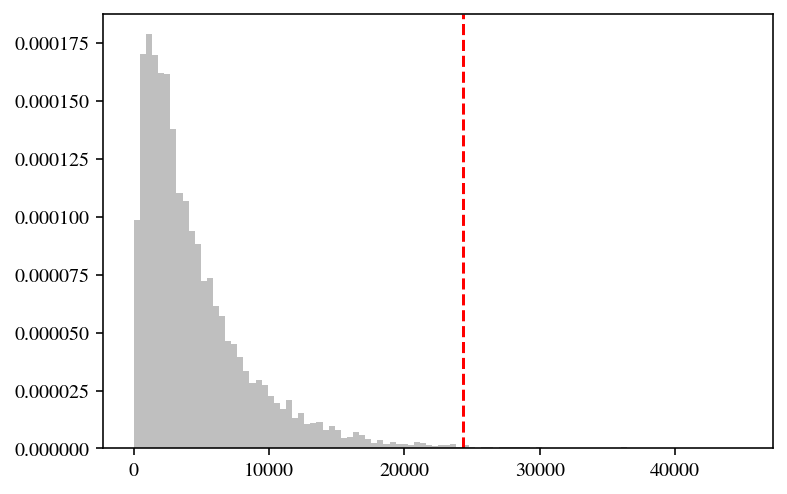

In [12]:
A_matrix = np.linalg.inv(cov_bar)

delta = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C)) \
      + np.dot(delta_theta_D.T,np.dot(A_matrix, delta_theta_D))

samples_H0 = np.zeros(num_samples)
for i in range(len(samples_H0)):
    samples_H0[i] = \
      np.dot(samps_delta_theta_A_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_A_H0[i,:])) \
    + np.dot(samps_delta_theta_B_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_B_H0[i,:]))\
    + np.dot(samps_delta_theta_C_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_C_H0[i,:]))\
      + np.dot(samps_delta_theta_D_H0[i,:].T,np.dot(A_matrix, samps_delta_theta_D_H0[i,:]))


plt.hist(samples_H0, bins=100, density=True, alpha=0.5, color='gray', label='H0 samples')
plt.axvline(delta, color='red', linestyle='--', label='delta')

print(samples_H0)
PTE = samples_H0[samples_H0 > delta].size/samples_H0.size
print('PTE: {}'.format(PTE))
print(r'$N \sigma$:{:4g}'.format(np.sqrt(2) * erfcinv(PTE)))

## $\epsilon$-stimator

\begin{equation}
    \epsilon = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

epsilon: 45.98105763752166
[11.92893241  5.47677201  6.68037178 ...  7.37510152  6.94736083
  1.59854667]
PTE: 0.0
$N \sigma$: inf


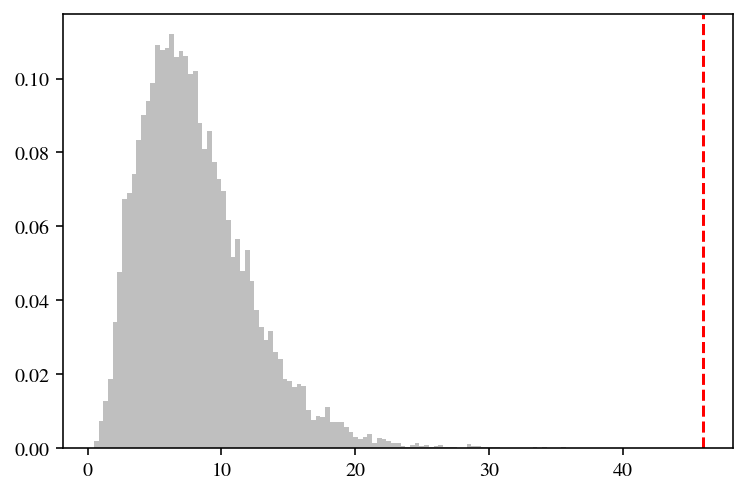

In [15]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C)) \
        + np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D + cov_bar), delta_theta_D))

print(r'epsilon: {}'.format(epsilon))

samples_H0 = np.zeros(num_samples)
for i in range(len(samples_H0)):
    samples_H0[i] = \
      np.dot(samps_delta_theta_A_H0[i,:].T,np.dot(np.linalg.inv(cov_A + cov_bar), samps_delta_theta_A_H0[i,:])) \
    + np.dot(samps_delta_theta_B_H0[i,:].T,np.dot(np.linalg.inv(cov_B + cov_bar), samps_delta_theta_B_H0[i,:]))\
    + np.dot(samps_delta_theta_C_H0[i,:].T,np.dot(np.linalg.inv(cov_C + cov_bar), samps_delta_theta_C_H0[i,:]))\
    + np.dot(samps_delta_theta_D_H0[i,:].T,np.dot(np.linalg.inv(cov_D + cov_bar), samps_delta_theta_D_H0[i,:]))
    


samples_H0 = np.array(samples_H0)
plt.hist(samples_H0, bins=100, density=True, alpha=0.5, color='gray', label='H0 samples')
plt.axvline(epsilon, color='red', linestyle='--', label='epsilon')

print(samples_H0)
PTE = samples_H0[samples_H0 > epsilon].size/samples_H0.size
print('PTE: {}'.format(PTE))
print(r'$N \sigma$:{:4g}'.format(np.sqrt(2) * erfcinv(PTE)))